# Compare MNDWI result between Landsat and Sentinal-2 data

* **Products used:**
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), [ls9_sr](https://explorer.digitalearth.africa/ls9_sr), 
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a)

In [1]:
pip install -q git+https://github.com/digitalearthafrica/deafrica-coastlines.git --disable-pip-version-check

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import geopandas as gpd
import xarray as xr
from sklearn.metrics import mean_absolute_error
from scipy import stats
from scipy.stats import gaussian_kde
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from shapely.geometry import Point, box

import os
import glob
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.coastal import tidal_tag
from deafrica_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from coastlines.vector import points_on_line, annual_movements, calculate_regressions

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


## Read in all files and find relationship between Landsat and Sentinel-2 MNDWI

In [3]:
# set path
MNDWIpath_lands = glob.glob('results/average_mndwi_landsat_?.csv')

MNDWIpath_sen = 'results/average_mndwi_sentinel_1.csv'

gdf_joined_pt =[]
gdf_joined_avg =[]
for MNDWIpath_land in MNDWIpath_lands:
    MNDWIpath_sen = MNDWIpath_land.replace('_landsat_','_sentinel_')
    # read data
    gdf_land = gpd.read_file(MNDWIpath_land)
    gdf_sen = gpd.read_file(MNDWIpath_sen)
    gdf_land = gdf_land.rename(columns={'X':'x','Y':'y'})
    gdf_sen = gdf_sen.rename(columns={'X':'x','Y':'y'})

    # check crs of two data
    SenCrs = gdf_sen.loc[0, 'spatial_ref']
    landCrs = gdf_land.loc[0, 'spatial_ref']

    # create landsat GeoDataFrame
    # creates a new point object for futher 
    gdf_land = gpd.GeoDataFrame( gdf_land ,geometry=gpd.points_from_xy(gdf_land.x, gdf_land.y))
    gdf_land['lon'] = gdf_land.geometry.apply(lambda p: p.x)
    gdf_land['lat'] = gdf_land.geometry.apply(lambda p: p.y)

    # set the GeoDataFrame coordinate system
    gdf_land = gdf_land.set_crs(epsg=landCrs)
    
    # convert Landsat coordinate system to the same of Sentinel coordinate system
    gdf_land_toSenCrs = gdf_land.to_crs(epsg=SenCrs)
    gdf_land_toSenCrs['lon'] = gdf_land_toSenCrs.geometry.apply(lambda p: p.x)
    gdf_land_toSenCrs['lat'] = gdf_land_toSenCrs.geometry.apply(lambda p: p.y)

    # change the X, Y value into integer 
    gdf_land_toSenCrs.lon = gdf_land_toSenCrs.lon.round().astype(int)
    gdf_land_toSenCrs.lat = gdf_land_toSenCrs.lat.round().astype(int)

    # create a new column for corresponding the landsat and sentinel GeoDataFrame
    gdf_land_toSenCrs = gdf_land_toSenCrs.assign(lon_lat=gdf_land_toSenCrs['lon'].astype(str) + '&' + gdf_land_toSenCrs['lat'].astype(str))

    # create Sentinal-2 GeoDataFrame
    gdf_sen = gpd.GeoDataFrame( gdf_sen ,geometry=gpd.points_from_xy(gdf_sen.x, gdf_sen.y))
    gdf_sen = gdf_sen.set_crs(epsg=SenCrs)

    # creates a new point object
    gdf_sen['lon'] = gdf_sen.geometry.apply(lambda p: p.x)
    gdf_sen['lat'] = gdf_sen.geometry.apply(lambda p: p.y)

    # change the X, Y value into integer 
    gdf_sen.lon = gdf_sen.lon.round().astype(int)
    gdf_sen.lat = gdf_sen.lat.round().astype(int)

    # create a new column for corresponding the landsat and sentinel GeoDataFrame
    gdf_sen = gdf_sen.assign(lon_lat=gdf_sen['lon'].astype(str) + '&' + gdf_sen['lat'].astype(str))
    
    # Usung inner join to merge two dataframe 
    inner_join_gdf = pd.merge(gdf_land_toSenCrs, gdf_sen[['lon_lat', 'MNDWI']], on='lon_lat')

    # rename the columns name 
    inner_join_gdf = inner_join_gdf.rename(columns={'MNDWI_x': 'MNDWI_landsat'})
    inner_join_gdf = inner_join_gdf.rename(columns={'MNDWI_y': 'MNDWI_sentinel'})

    # convert the data into numeric 
    inner_join_gdf['MNDWI_landsat'] = pd.to_numeric(inner_join_gdf['MNDWI_landsat'], errors='coerce')
    inner_join_gdf['MNDWI_sentinel'] = pd.to_numeric(inner_join_gdf['MNDWI_sentinel'], errors='coerce')

    #delete the row that contain NaN
    inner_join_gdf.dropna(inplace=True)

    gdf_joined_pt.append(inner_join_gdf)
    
    # create grid based on landsat data
    # Using landsat point as the centroid to calculate the extent of grid
    gdf_land_toSenCrs = gdf_land_toSenCrs.assign(lon_left = gdf_land_toSenCrs['lon'] -15, lon_right = gdf_land_toSenCrs['lon'] + 15, lat_top = gdf_land_toSenCrs['lat'] +15, lat_down = gdf_land_toSenCrs['lat'] - 15)

    # check the value of the extent
    xmin = gdf_land_toSenCrs['lon_left'].min()
    xmax = gdf_land_toSenCrs['lon_right'].max()
    ymax = gdf_land_toSenCrs['lat_top'].max()
    ymin = gdf_land_toSenCrs['lat_down'].min()

    # create a 30*30 grid
    cell_size = 30

    grid_cells = []
    for x0 in np.arange(xmin + cell_size, xmax, cell_size ):
        for y0 in np.arange(ymin, ymax + cell_size, cell_size):
            # bounds
            x1 = x0 - cell_size
            y1 = y0 + cell_size
            grid_cells.append(box(x0, y0, x1, y1)  )
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])

    # add a ID column for spatial join corresponding 
    cell['ID'] = range(1, len(cell) + 1)
    # set the coordinate system
    cell = cell.set_crs(epsg=SenCrs)

    # Using the created grid to spatial join sentinel and landsat data 
    # Calculate the all sentinel's MNDWI values in each grid
    Sjoin_sen = cell.sjoin(gdf_sen)
    Sjoin_sen['MNDWI'] = pd.to_numeric(Sjoin_sen['MNDWI'], errors='coerce')
    grid_avg_values_sen = Sjoin_sen.groupby('ID')['MNDWI'].mean()
    cell['MNDWI_sentinel'] = grid_avg_values_sen

    # Calculate the all landsat's MNDWI values in each grid
    Sjoin_land = cell.sjoin(gdf_land_toSenCrs)
    Sjoin_land['MNDWI'] = pd.to_numeric(Sjoin_land['MNDWI'], errors='coerce')
    grid_avg_values_land = Sjoin_land.groupby('ID')['MNDWI'].mean()
    cell['MNDWI_landsat'] = grid_avg_values_land

    #delete the row that contain NaN
    cell.dropna(inplace=True)

    gdf_joined_avg.append(cell)


In [4]:
gdf_merged_pt = pd.concat(gdf_joined_pt)
gdf_merged_avg = pd.concat(gdf_joined_avg)

linear eq: landsat_MNDWI = 0.963*sentinel_MNDWI + -0.023
MAE:  0.07




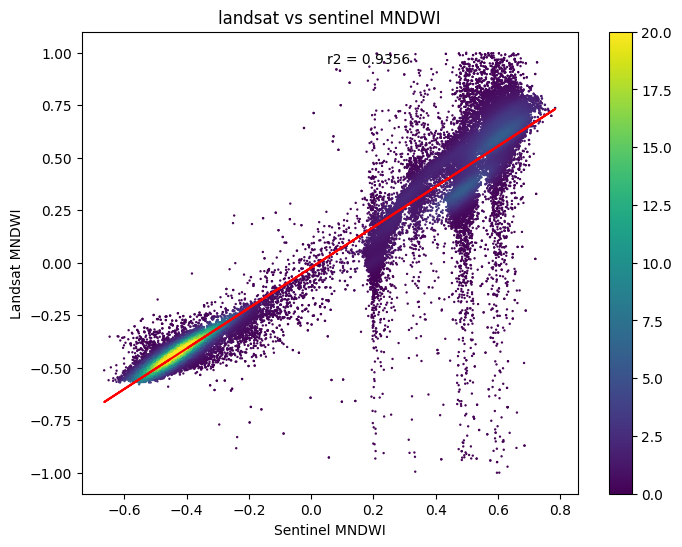

In [5]:
mndwi_bound = 1

# Visualise the comparison that only calculated data that have intersected.
y = gdf_merged_pt['MNDWI_landsat'].values
x = gdf_merged_pt['MNDWI_sentinel'].values

ind = (np.abs(x)<mndwi_bound) & (np.abs(y)<mndwi_bound)
x = x[ind]
y = y[ind]
slope, intercept, r, p, sd = stats.linregress(x, y)
mae = mean_absolute_error(x,y)

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

print(f'linear eq: landsat_MNDWI = {slope:.3f}*sentinel_MNDWI + {intercept:.3f}')
print("MAE: ", round(mae, 3))
print('\n')

fig, ax = plt.subplots(1,1, sharey=True, figsize=(8,6))
plt.scatter(x, y, c=z, s=0.5)
plt.plot(x, intercept + slope * x, '-', c='red')
plt.clim(0,20)
plt.colorbar()
plt.text(0.05,0.95,"r2 = "+str(round(r**2,4)))
#ax.set_xlim(-1.0, 1.0)
#ax.set_ylim(-1.0, 1.0)
#ax.plot([-1, 1], [-1, 1], 'k-')
ax.set_xlabel('Sentinel MNDWI')
ax.set_ylabel('Landsat MNDWI')
ax.set_title('landsat vs sentinel MNDWI');

## Optimal water detection thresholds for Landsat and Sentinel-2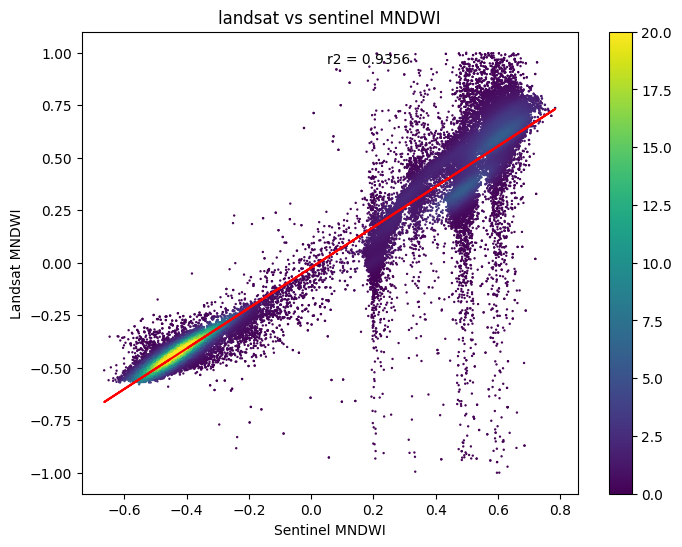

In [6]:
from skimage.filters import threshold_minimum, threshold_otsu

threshold_ls_min = threshold_minimum(y)
threshold_ls_otsu = threshold_otsu(y)

threshold_s2_min = threshold_minimum(x)
threshold_s2_otsu = threshold_otsu(x)

print("Landsat threshods:", threshold_ls_min, threshold_ls_otsu)
print("Sentinel threshods:", threshold_s2_min, threshold_s2_otsu)


Landsat threshods: -0.05852250351562499 0.027408181640625084
Sentinel threshods: 0.005622055175781293 0.033904907714843835


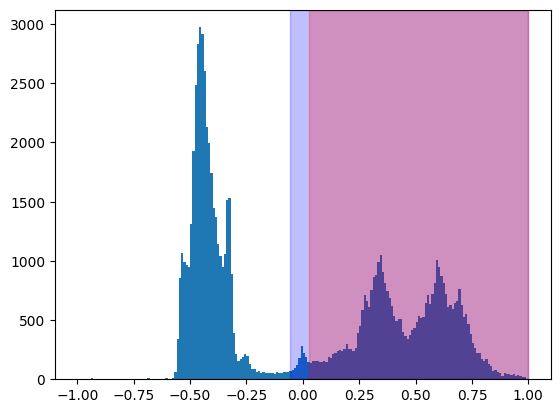

In [7]:
plt.hist(y, bins=np.arange(-1,1,0.01), label="Landsat");
plt.axvspan(xmin=threshold_ls_min, xmax=1, alpha=0.25, color="blue", label="Water (min)")
plt.axvspan(xmin=threshold_ls_otsu, xmax=1, alpha=0.25, color="red", label="Water (otsu)")

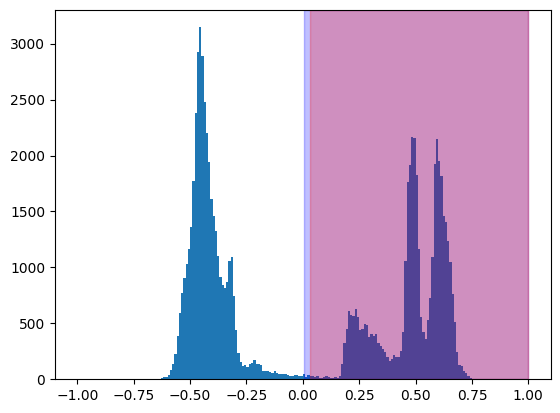

In [8]:
plt.hist(x, bins=np.arange(-1,1,0.01), label="Sentinel");
plt.axvspan(xmin=threshold_s2_min, xmax=1, alpha=0.25, color="blue", label="Water (min)")
plt.axvspan(xmin=threshold_s2_otsu, xmax=1, alpha=0.25, color="red", label="Water (otsu)")

## Alternative method to join the results

linear eq: landsat_MNDWI = 0.966*sentinel_MNDWI + -0.023
MAE:  0.067




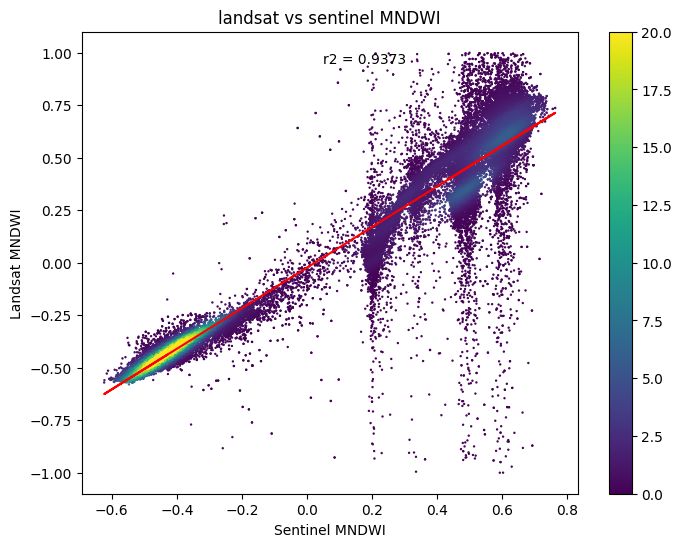

In [9]:

# Visualise the comparison that only calculated data that have intersected.
y = gdf_merged_avg['MNDWI_landsat'].values
x = gdf_merged_avg['MNDWI_sentinel'].values

ind = (np.abs(x)<mndwi_bound) & (np.abs(y)<mndwi_bound)
x = x[ind]
y = y[ind]
slope, intercept, r, p, sd = stats.linregress(x, y)
mae = mean_absolute_error(x,y)

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

print(f'linear eq: landsat_MNDWI = {slope:.3f}*sentinel_MNDWI + {intercept:.3f}')
print("MAE: ", round(mae, 3))
print('\n')

fig, ax = plt.subplots(1,1, sharey=True, figsize=(8,6))
plt.scatter(x, y, c=z, s=0.5)
plt.plot(x, intercept + slope * x, '-', c='red')
plt.clim(0,20)
plt.colorbar()
plt.text(0.05,0.95,"r2 = "+str(round(r**2,4)))
#ax.set_xlim(-1.0, 1.0)
#ax.set_ylim(-1.0, 1.0)
#ax.plot([-1, 1], [-1, 1], 'k-')
ax.set_xlabel('Sentinel MNDWI')
ax.set_ylabel('Landsat MNDWI')
ax.set_title('landsat vs sentinel MNDWI');

In [10]:
threshold_ls_min = threshold_minimum(y)
threshold_ls_otsu = threshold_otsu(y)

threshold_s2_min = threshold_minimum(x)
threshold_s2_otsu = threshold_otsu(x)

print("Landsat threshods:", threshold_ls_min, threshold_ls_otsu)
print("Sentinel threshods:", threshold_s2_min, threshold_s2_otsu)


Landsat threshods: -0.05852250351562499 0.027408181640625084
Sentinel threshods: 0.002291928302951385 0.03478225658420142


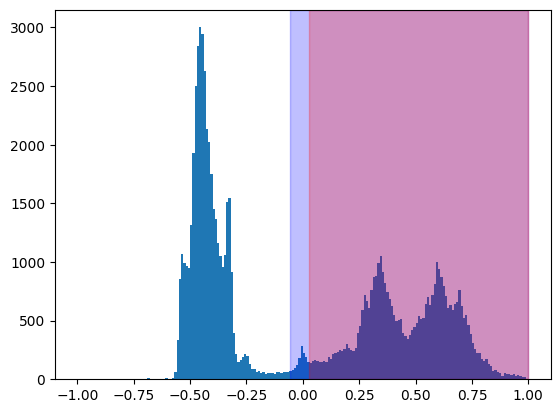

In [11]:
plt.hist(y, bins=np.arange(-1,1,0.01), label="Landsat");
plt.axvspan(xmin=threshold_ls_min, xmax=1, alpha=0.25, color="blue", label="Water (min)")
plt.axvspan(xmin=threshold_ls_otsu, xmax=1, alpha=0.25, color="red", label="Water (otsu)")

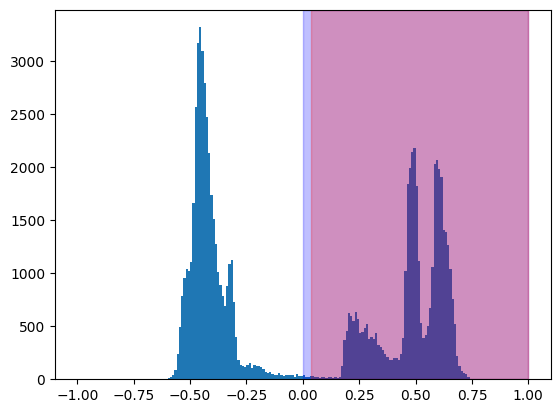

In [12]:
plt.hist(x, bins=np.arange(-1,1,0.01), label="Sentinel");
plt.axvspan(xmin=threshold_s2_min, xmax=1, alpha=0.25, color="blue", label="Water (min)")
plt.axvspan(xmin=threshold_s2_otsu, xmax=1, alpha=0.25, color="red", label="Water (otsu)")